In [1]:
## Notebook to demonstrate, benchmark, and cross validate model prediction and forecasting capabilities. ##
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from scipy import signal
import os
import datetime

# Set environment variables for AMD ROCM (comment if unnecessary)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'

# Load data
weather_data = pd.read_csv('london_weather.csv')
weather_data = weather_data[['date', 'mean_temp', 'sunshine','global_radiation','max_temp','min_temp']]
weather_data = weather_data.set_index('date', drop = True)
weather_data.index = pd.to_datetime(weather_data.index,format="%Y%m%d")
# Interpolate NaNs in dataset
weather_data = weather_data.interpolate(method='time')

2023-04-05 22:52:24.945947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Convert to values
values = weather_data.values
training_data_len = math.ceil(len(values)*0.8 )

# Apply 4th order low pass butterworth at period of 1/0.03 days
b, a = signal.iirfilter(4, 0.03, btype="low", ftype="butter")
print("Butterworth filter: \n")
print(b, a, sep="\n")
values_filt = [None] * 5
for i in range(5):
    values_filt[i] = signal.filtfilt(b, a , values[:,i])
values_filt = np.array(values_filt).transpose()

# Normalise to scale between 0 to 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values_filt)

# Generate training and testing feature vectors
train_data = scaled_data[0: training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i])
    
x_train, y_train = np.array(x_train), np.array(y_train)

#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Butterworth filter: 

[4.37268880e-06 1.74907552e-05 2.62361328e-05 1.74907552e-05
 4.37268880e-06]
[ 1.         -3.75376276  5.29115258 -3.3189386   0.78161874]


In [3]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = scaled_data[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i])

x_test = np.array(x_test)

In [4]:
# Load the pretrained model
model = keras.models.load_model("lstm_model")
predictions = model.predict(x_test)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print("The rmse for this prediction is: " + str(rmse))

predictions = scaler.inverse_transform(predictions)

96/96 [==============================] - 1s 1ms/step
The rmse for this prediction is: 9.970832120913999e-05


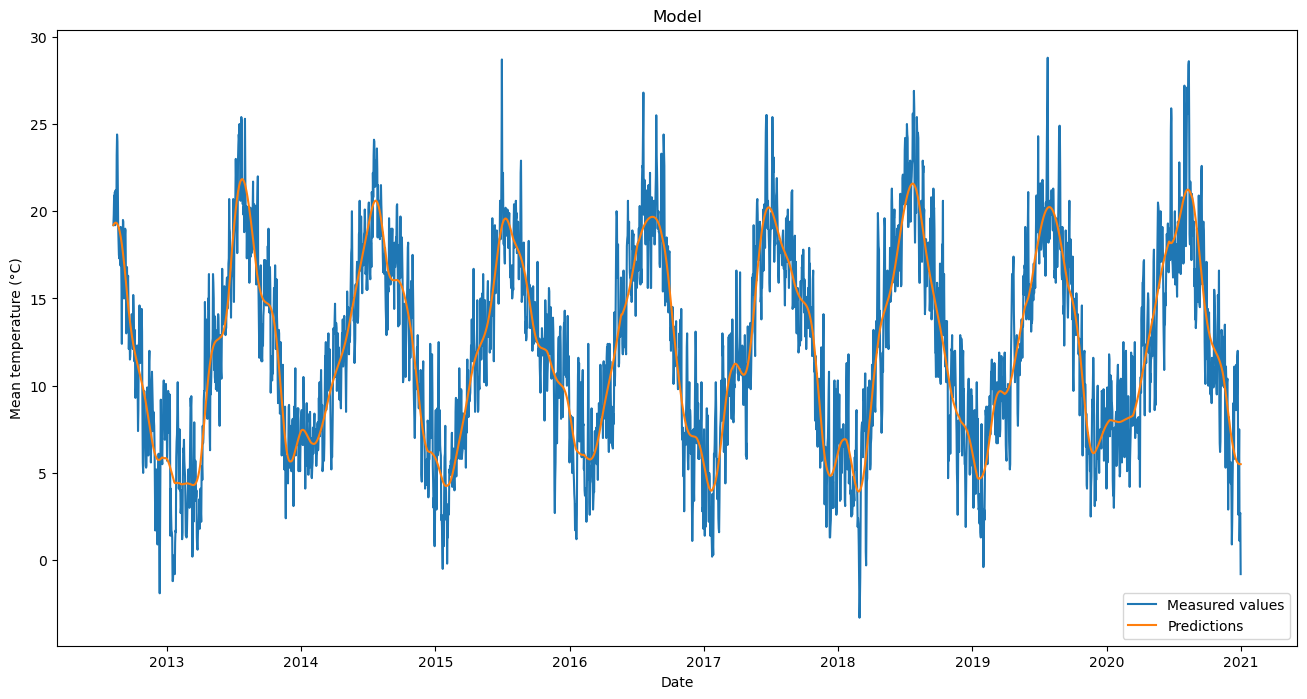

In [5]:
# Plot validation predictions
data = weather_data
train = data[:training_data_len]
validation = data[training_data_len:]
df = pd.DataFrame(predictions, columns = ['Pred_mean_temp', 'Pred_sunshine','Pred_global_radiation','Pred_max_temp','Pred_min_temp'])
df.index = validation.index
validation = pd.concat([validation,df],axis=1)
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Mean temperature (\N{DEGREE SIGN}C)')
#plt.plot(train)
plt.plot(validation[['mean_temp','Pred_mean_temp']])
plt.legend(['Measured values', 'Predictions'], loc='lower right')
plt.show()

In [6]:
# Generate the multi-step forecasts
# Set date to forecast to
date = '2024-12-31'
current_date = datetime.datetime.strptime(date,"%Y-%m-%d").date()
last_date = datetime.date(2019, 12, 31)
delta = current_date - last_date
# Find difference in days
n_future = delta.days


In [7]:
y_future = []
x_pred = x_test[-1:, :, :]  # last observed input sequence
y_pred = y_test[-1]         # last observed target value

for i in range(n_future):

    # feed the last forecast back to the model as an input
    x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1,1,5), axis=1)

    # generate the next forecast
    y_pred = model.predict(x_pred)

    # save the forecast
    y_future.append(y_pred)

# transform the forecasts back to the original scale
y_future = np.array(y_future).reshape(-1,5)
y_future = scaler.inverse_transform(y_future)

1/1 [==============================] - 0s 9ms/step


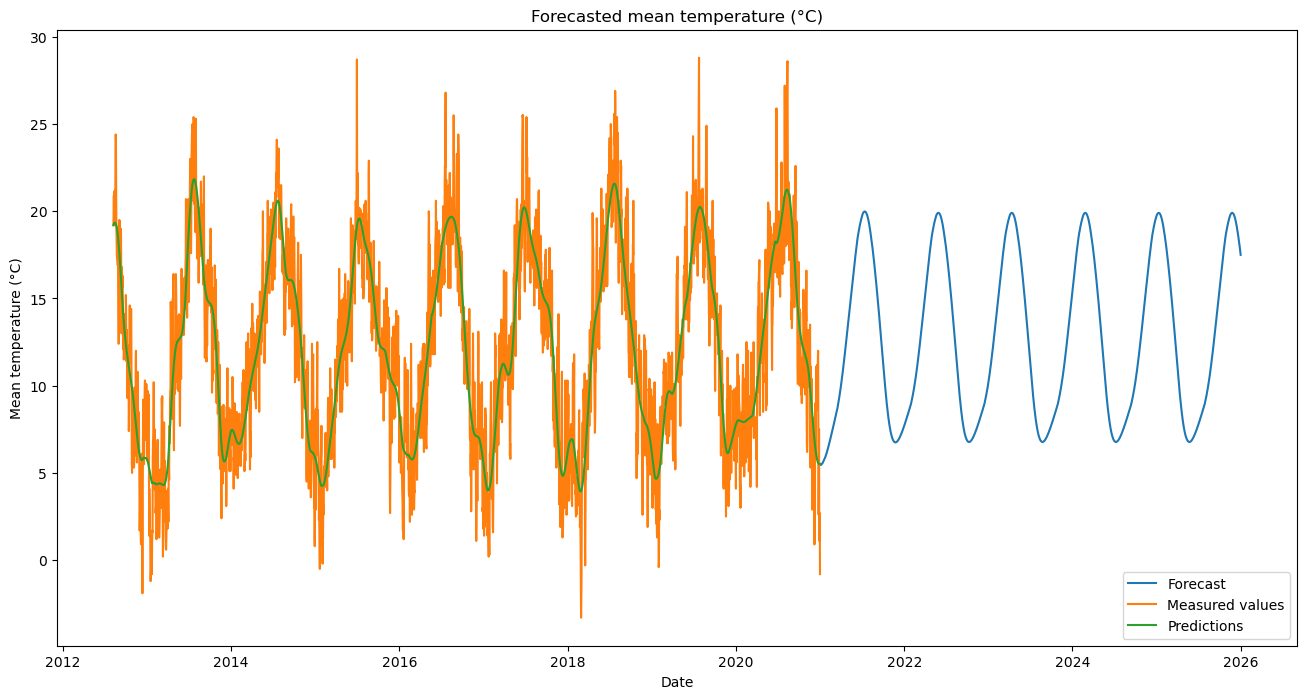

In [8]:
df_future = pd.DataFrame(y_future, columns = ['Pred_mean_temp', 'Pred_sunshine','Pred_global_radiation','Pred_max_temp','Pred_min_temp'])
df_future['Date'] = pd.date_range(start='2020-12-31', periods=n_future)
df_future = df_future.set_index('Date')

# Plot forecasted data
plt.figure(figsize=(16,8))
plt.title('Forecasted mean temperature (\N{DEGREE SIGN}C)')
plt.xlabel('Date')
plt.ylabel('Mean temperature (\N{DEGREE SIGN}C)')
plt.plot(df_future['Pred_mean_temp'])
plt.plot(validation[['mean_temp', 'Pred_mean_temp']])
plt.legend(['Forecast','Measured values', 'Predictions'], loc='lower right')
plt.show()

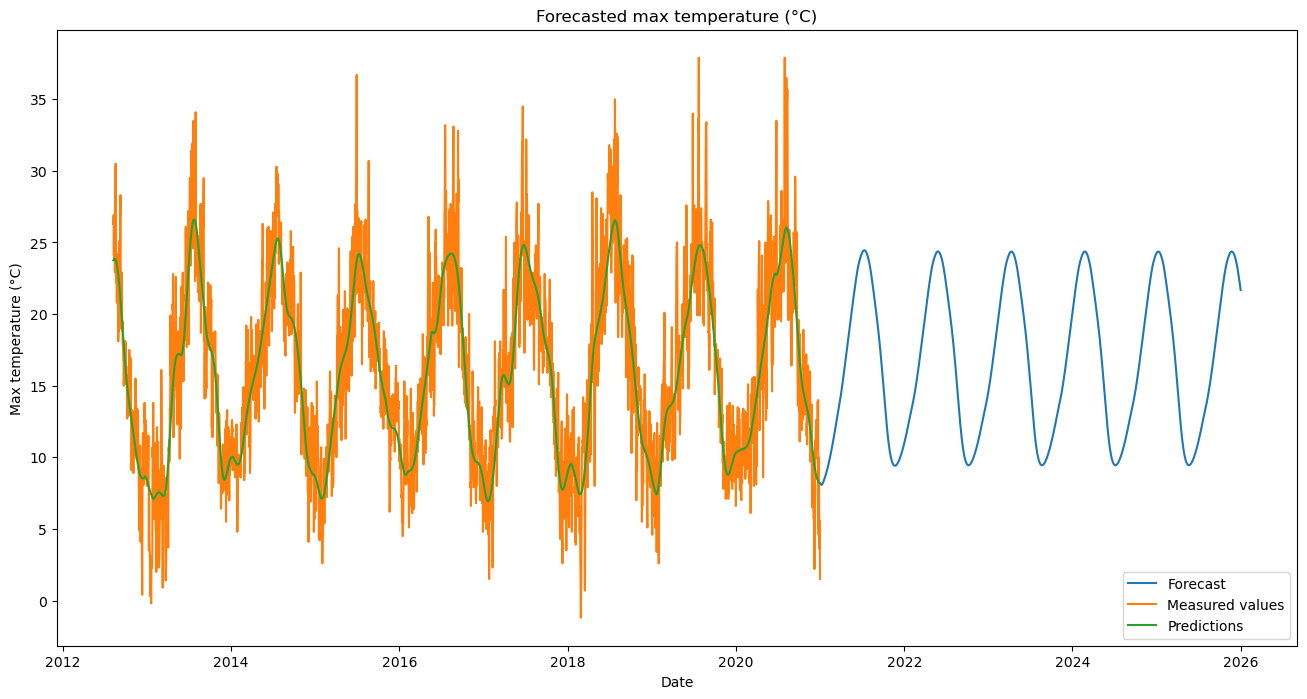

In [9]:
plt.figure(figsize=(16,8))
plt.title('Forecasted max temperature (\N{DEGREE SIGN}C)')
plt.xlabel('Date')
plt.ylabel('Max temperature (\N{DEGREE SIGN}C)')
plt.plot(df_future['Pred_max_temp'])
plt.plot(validation[['max_temp', 'Pred_max_temp']])
plt.legend(['Forecast','Measured values', 'Predictions'], loc='lower right')
plt.show()

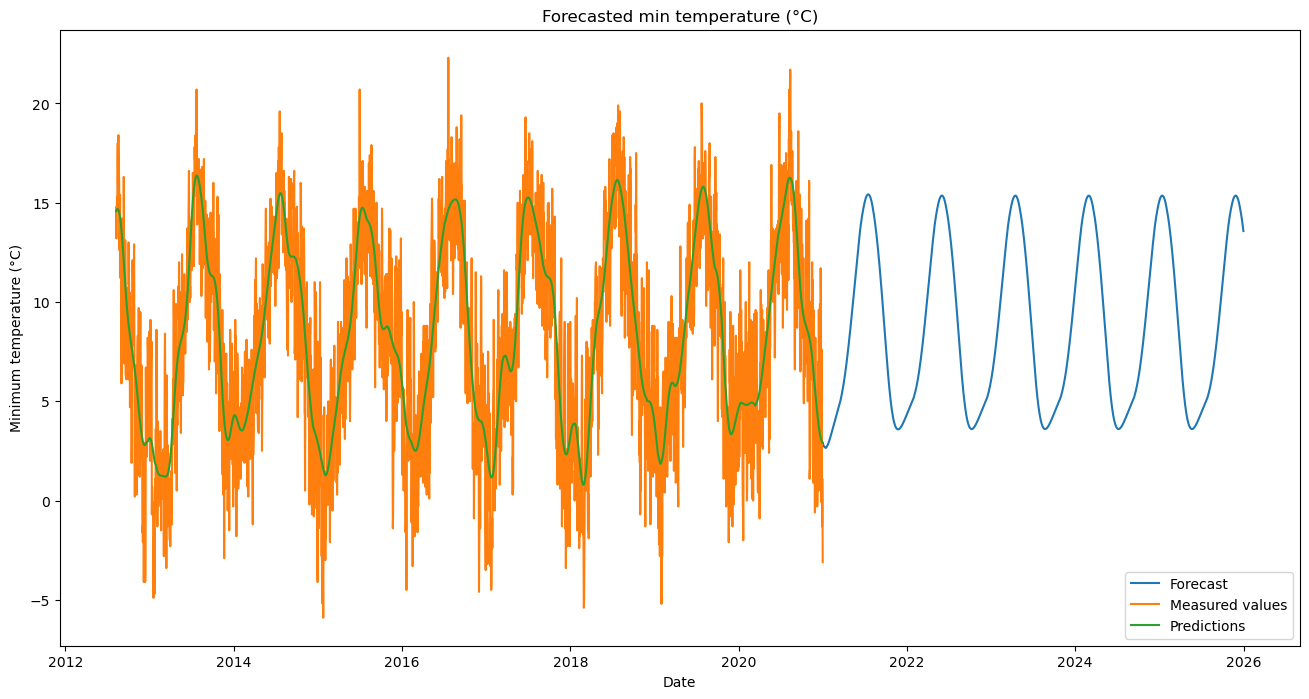

In [10]:
plt.figure(figsize=(16,8))
plt.title('Forecasted min temperature (\N{DEGREE SIGN}C)')
plt.xlabel('Date')
plt.ylabel('Minimum temperature (\N{DEGREE SIGN}C)')
plt.plot(df_future['Pred_min_temp'])
plt.plot(validation[['min_temp', 'Pred_min_temp']])
plt.legend(['Forecast','Measured values', 'Predictions'], loc='lower right')
plt.show()

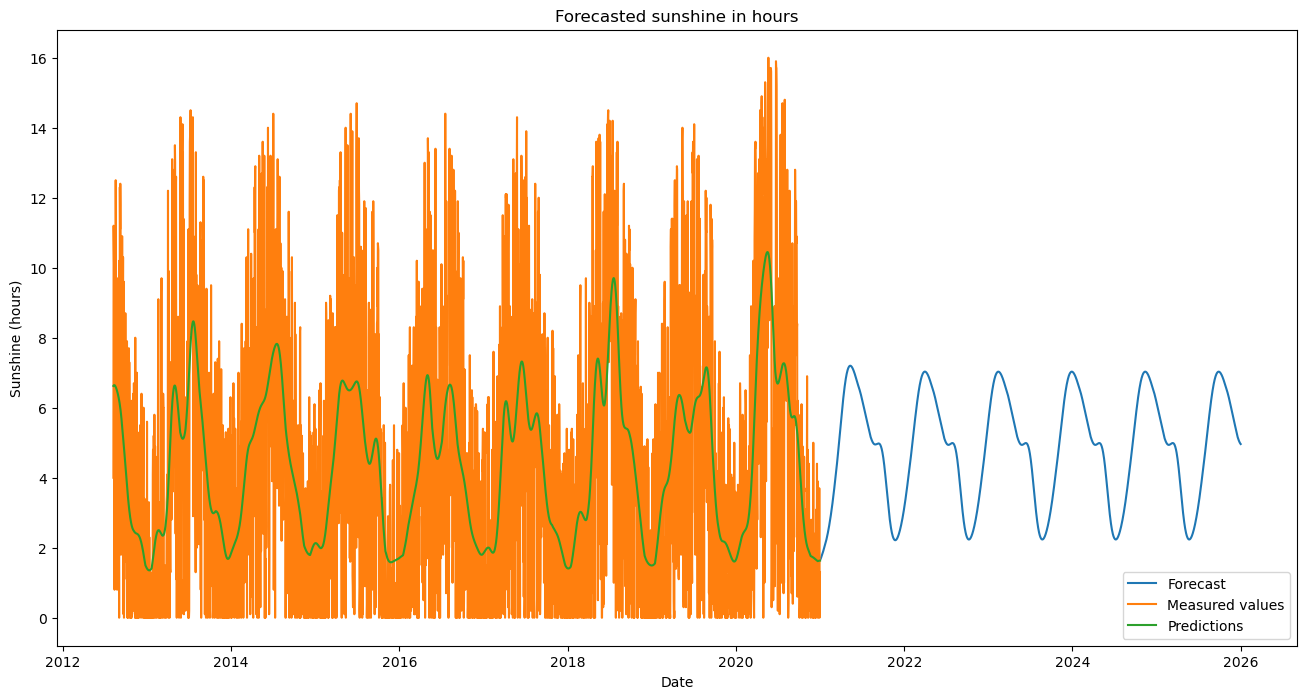

In [11]:
plt.figure(figsize=(16,8))
plt.title('Forecasted sunshine in hours')
plt.xlabel('Date')
plt.ylabel('Sunshine (hours)')
plt.plot(df_future['Pred_sunshine'])
plt.plot(validation[['sunshine', 'Pred_sunshine']])
plt.legend(['Forecast','Measured values', 'Predictions'], loc='lower right')
plt.show()

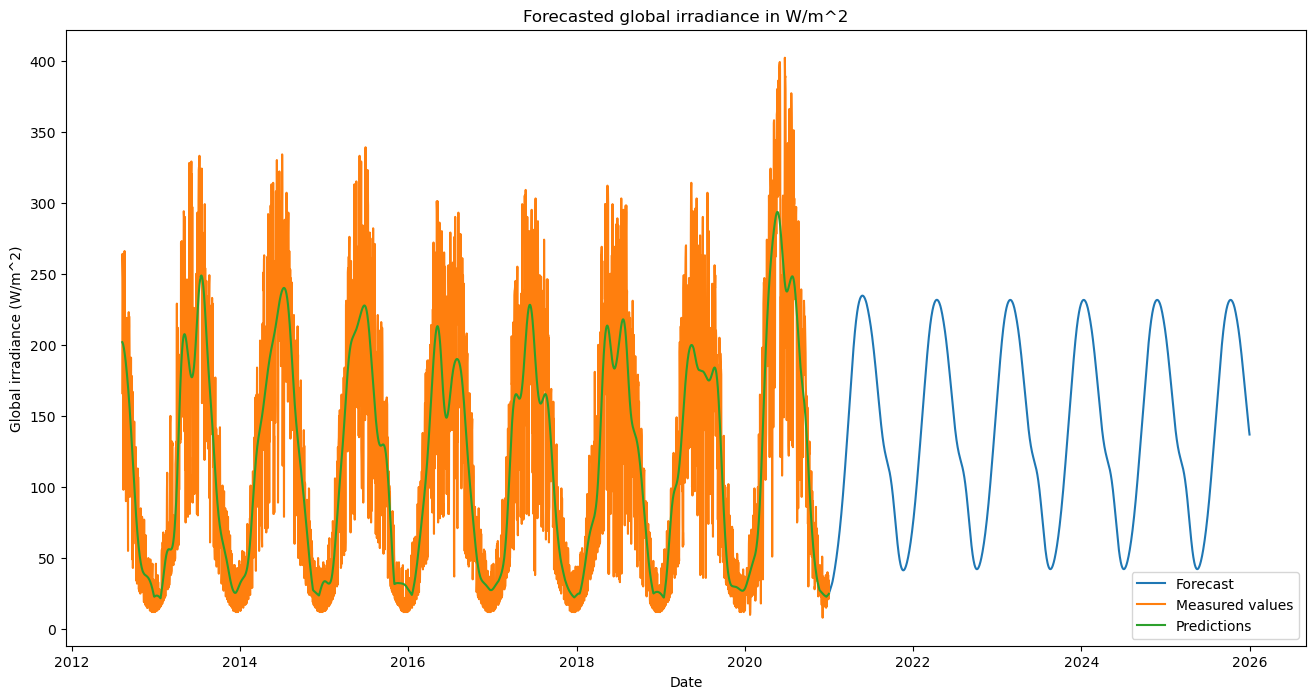

In [12]:
plt.figure(figsize=(16,8))
plt.title('Forecasted global irradiance in W/m^2')
plt.xlabel('Date')
plt.ylabel('Global irradiance (W/m^2)')
plt.plot(df_future['Pred_global_radiation'])
plt.plot(validation[['global_radiation', 'Pred_global_radiation']])
plt.legend(['Forecast','Measured values', 'Predictions'], loc='lower right')
plt.show()